# <center> $$Catboost\ hyperparameters\ tuning$$

## 1.  Connecting to GitHub and installing libraries


In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
%cd /content/drive/MyDrive/1_NYC_taxi/

/content/drive/MyDrive/1_NYC_taxi


In [67]:
import pandas as pd

In [68]:
github_invite = pd.read_csv('github_invite.csv')
user = github_invite['user'][0]
repo = github_invite['repo'][0]
token = github_invite['token'][0]

!git clone https://{token}@github.com/{user}/{repo}

Cloning into 'nyc_taxi_trip_proj'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 205 (delta 70), reused 169 (delta 37), pack-reused 0
Receiving objects: 100% (205/205), 10.25 MiB | 11.12 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [69]:
%cd nyc_taxi_trip_proj/backend/notebooks/

/content/drive/MyDrive/1_NYC_taxi/nyc_taxi_trip_proj/backend/notebooks


In [ ]:
!pip install catboost==1.0.6
!pip install PyYAML==6.0
!pip install optuna==2.10.1
!pip install shap==0.41.0

In [8]:
import yaml
import shap
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from optuna import create_study
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import sys
sys.path.append('../')
from src import clean_data, get_data, add_features, upload_config

# 2. Data Preprocessing

In [9]:
!pwd

/content/drive/MyDrive/1_NYC_taxi/nyc_taxi_trip_proj/backend/notebooks


In [70]:
# config
cfg = upload_config('../config/params.yaml')
test_size = cfg['data_split']['test_size']
test_split_seed = cfg['data_split']['test_split_seed']
valid_size = cfg['data_split']['valid_size']
valid_split_seed = cfg['data_split']['valid_split_seed']

In [11]:
# data preprocessing
path = 'https://github.com/EuMentality/datasets/raw/main/taxi_trip.csv'
df = add_features(clean_data(get_data(path)), purpose='tuning')

In [12]:
# processing for tuning & testing
X = df.drop('trip_duration', axis=1)
y = df.trip_duration

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=test_split_seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valid_size, random_state=valid_split_seed)

cat_feature_indices = np.array([0, 5, 6, 8, 9]) 
train_pool = Pool(X_train, y_train, cat_features=cat_feature_indices)
val_pool = Pool(X_val, y_val, cat_features=cat_feature_indices)
test_pool = Pool(X_test, y_test, cat_features=cat_feature_indices)

# 3. Catboost tuning

## 3.1 Best Params Searching

In [13]:
params_defolt = {
                'iterations': 1500,
                'boosting_type': 'Plain',
                'bootstrap_type': 'Bernoulli',
                'use_best_model': True,
                'verbose': False,
                'task_type': 'GPU',
                'random_state': 20
                }

In [14]:
def objective(trial):
    params_search = {
        "learning_rate": trial.suggest_uniform("learning_rate", 1e-3, 1e-1), 
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 2e-1, 20e0),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0), 
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "depth": trial.suggest_int("depth", 4, 16)
        }

    model = CatBoostRegressor(**params_defolt, **params_search)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=30)
    print(f"N trees = {model.tree_count_}")
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test, y_pred, squared=False)
    return score

In [ ]:
study = create_study(sampler=TPESampler(), direction="minimize")
study.optimize(objective, n_trials=50)

In [ ]:
# Best Params
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [43]:
# updating params
for key, value in trial.params.items():
    params_defolt[key] = value

## 3.2 Finding N Estimators

In [19]:
catboost_final = CatBoostRegressor(**params_defolt)
catboost_final.fit(train_pool, eval_set=val_pool,early_stopping_rounds=30, verbose=200)
n_estimators = catboost_final.tree_count_

0:	learn: 0.6781265	test: 0.6846861	best: 0.6846861 (0)	total: 93.7ms	remaining: 2m 20s
200:	learn: 0.3521053	test: 0.3775159	best: 0.3775159 (200)	total: 12.1s	remaining: 1m 17s
400:	learn: 0.3306317	test: 0.3712890	best: 0.3712890 (400)	total: 22.9s	remaining: 1m 2s
600:	learn: 0.3165642	test: 0.3684677	best: 0.3684677 (600)	total: 33.8s	remaining: 50.5s
800:	learn: 0.3053246	test: 0.3668930	best: 0.3668930 (800)	total: 44.7s	remaining: 39s
1000:	learn: 0.2961449	test: 0.3653908	best: 0.3653908 (1000)	total: 56.2s	remaining: 28s
1200:	learn: 0.2881641	test: 0.3646372	best: 0.3646310 (1199)	total: 1m 7s	remaining: 16.7s
1400:	learn: 0.2808225	test: 0.3641023	best: 0.3640509 (1383)	total: 1m 18s	remaining: 5.52s
bestTest = 0.3640509467
bestIteration = 1383
Shrink model to first 1384 iterations.


In [20]:
print(f'Best number of trees = {n_estimators}')

Best number of trees = 1384


In [21]:
params_defolt['iterations'] = n_estimators
params_defolt['use_best_model'] = False
best_params = params_defolt

In [22]:
best_params

{'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'depth': 11,
 'iterations': 1384,
 'l2_leaf_reg': 0.3752182870326149,
 'learning_rate': 0.06480627095654698,
 'random_state': 20,
 'subsample': 0.9957290923886816,
 'task_type': 'GPU',
 'use_best_model': False,
 'verbose': False}

## 4. Model Quality Estimation

In [45]:
X_train_last = pd.concat([X_train, X_val])
y_train_last = pd.concat([y_train, y_val])
train_pool_last = Pool(X_train_last, y_train_last, cat_features=cat_feature_indices)

In [24]:
best_catboost = CatBoostRegressor(**best_params)
best_catboost.fit(train_pool_last)

In [25]:
y_test_predict = best_catboost.predict(X_test)
y_train_predict = best_catboost.predict(X_train)

In [26]:
msle_train = np.round(mean_squared_error(y_train, y_train_predict), 2)
msle_test = np.round(mean_squared_error(y_test, y_test_predict), 2)

rmse_minutes_train = np.round(mean_squared_error(np.exp(y_train)/60, np.exp(y_train_predict)/60)**0.5, 2)
rmse_minutes_test = np.round(mean_squared_error(np.exp(y_test)/60, np.exp(y_test_predict)/60)**0.5, 2)

r2_train = np.round(r2_score(y_train, y_train_predict), 2)
r2_test = np.round(r2_score(y_test, y_test_predict), 2)

In [27]:
print(f'MSLE Train = {msle_train}')
print(f'MSLE Test = {msle_test}', '\n')
print(f'RMSE in Minutes Train = {rmse_minutes_train}')
print(f'RMSE in Minutes Test = {rmse_minutes_test}', '\n')
print(f'r2 Train = {r2_train}')
print(f'r2 Test = {r2_test}')

MSLE Train = 0.09
MSLE Test = 0.13 

RMSE in Minutes Train = 3.89
RMSE in Minutes Test = 4.12 

r2 Train = 0.83
r2 Test = 0.75


# 5. Feature Importance


## 5.1 Overall 
For each feature shows how much on average the prediction changes if the feature value changes. The bigger the value of the importance the bigger on average is the change to the prediction value, if this feature is changed. Feature importance values are normalized so that the sum of importances of all features is equal to 100

In [28]:
best_catboost.get_feature_importance(prettified=True)

,Feature Id,Importances
0,manh_length,26.950801
1,dropoff_latitude,13.275793
2,pickup_hour,10.638829
3,pickup_weekday,9.769513
4,dropoff_longitude,9.667790
5,pickup_longitude,9.103689
6,pickup_latitude,8.746851
7,high_traffic,6.331876
8,pickup_month,5.468970
9,anomaly,0.033203


## 5.2 SHAP values
A vector with contributions of each feature to the prediction for every input object and the expected value of the model prediction for the object (average prediction given no knowledge about the object).

In [31]:
vals = np.random.randint(0, X.shape[0], size=3000)

In [32]:
explainer = shap.TreeExplainer(best_catboost)
shap_values = explainer.shap_values(Pool(X.iloc[vals, :], y[vals], cat_features=cat_feature_indices))

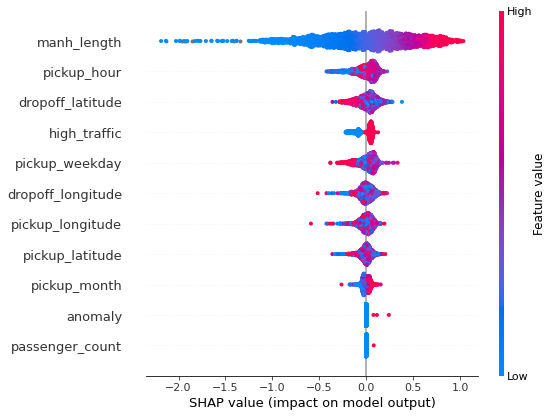

In [34]:
shap.summary_plot(shap_values, X.iloc[vals, :],)

## 6. Saving Params

In [72]:
with open('../config/params.yaml', 'w') as config:
    cfg['hyperparams'] = best_params
    yaml.safe_dump(cfg, config, default_flow_style=False)

In [78]:
!git add .


In [79]:
!git commit -m "add catboost tuning notebook"


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@211d7ad74cef.(none)')


In [80]:
!git config --global user.email "val.mitkv@yandex.ru"
!git config --global user.name "valek"

In [81]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	new file:   1_catboost_tuning.ipynb

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ../config/params.yaml
	deleted:    1_catboost_tuning.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	catboost tuning.ipynb



In [82]:
!git add

Nothing specified, nothing added.
Maybe you wanted to say 'git add .'?


In [ ]:
!git commit -m "add catboost tuning notebook"